In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

In [328]:
train = pd.read_csv('data/train.csv')
# train_extra = pd.read_csv('data/training_extra.csv')

In [329]:
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [330]:
# train_extra.shape

In [331]:
3694318+300000

3994318

In [332]:
# train = pd.concat([train, train_extra], ignore_index=True, axis=0)

<Axes: xlabel='Price', ylabel='Count'>

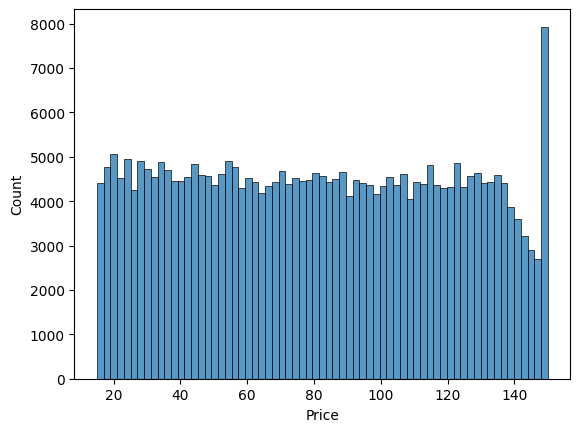

In [333]:
sns.histplot(train['Price'])

<Axes: xlabel='Weight Capacity (kg)', ylabel='Price'>

c:\Users\modern14\VSCode\GitHub\my-portfolio\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


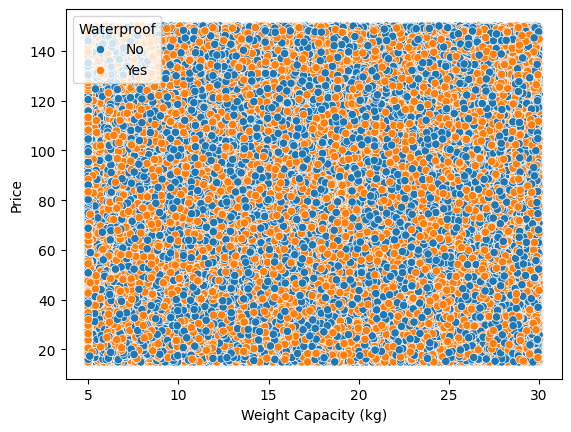

In [334]:
sns.scatterplot(train[train.Price < 150], x='Weight Capacity (kg)', y='Price', hue='Waterproof')

In [335]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [336]:
train.isna().sum() / len(train) * 100

id                      0.000000
Brand                   3.235000
Material                2.782333
Size                    2.198333
Compartments            0.000000
Laptop Compartment      2.481333
Waterproof              2.350000
Style                   2.656667
Color                   3.316667
Weight Capacity (kg)    0.046000
Price                   0.000000
dtype: float64

In [337]:
[(i, train[i].unique()) if train[i].nunique() <= 10 else (i, train[i].nunique()) for i in train.columns]

[('id', 300000),
 ('Brand',
  array(['Jansport', 'Under Armour', 'Nike', 'Adidas', 'Puma', nan],
        dtype=object)),
 ('Material',
  array(['Leather', 'Canvas', 'Nylon', nan, 'Polyester'], dtype=object)),
 ('Size', array(['Medium', 'Small', 'Large', nan], dtype=object)),
 ('Compartments', array([ 7., 10.,  2.,  8.,  1.,  3.,  5.,  9.,  6.,  4.])),
 ('Laptop Compartment', array(['Yes', 'No', nan], dtype=object)),
 ('Waterproof', array(['No', 'Yes', nan], dtype=object)),
 ('Style', array(['Tote', 'Messenger', nan, 'Backpack'], dtype=object)),
 ('Color',
  array(['Black', 'Green', 'Red', 'Blue', 'Gray', 'Pink', nan], dtype=object)),
 ('Weight Capacity (kg)', 181596),
 ('Price', 48212)]

<Axes: xlabel='Price', ylabel='Count'>

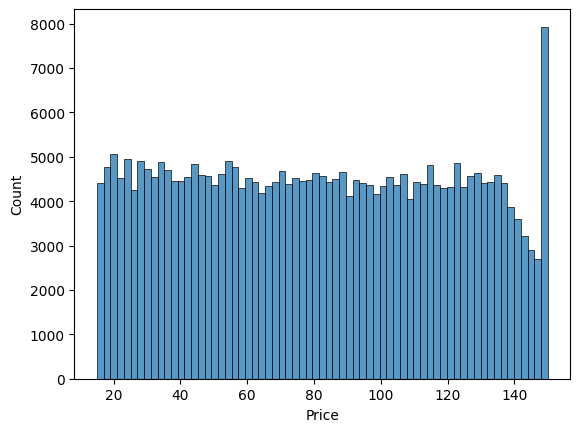

In [338]:
sns.histplot(train.Price)

In [339]:
train.Price.value_counts()

Price
150.00000    5528
15.00000      693
23.59584       22
17.31514       21
62.36063       21
             ... 
82.31121        1
90.79389        1
111.37389       1
94.99611        1
41.96325        1
Name: count, Length: 48212, dtype: int64

In [340]:
train = train[train.Price < 150]

In [341]:
# [train[i].mode() for i in train.columns.drop('id')]

In [342]:
X_train = train.drop('Price', axis=1)
y_train = train.Price

<Axes: ylabel='Frequency'>

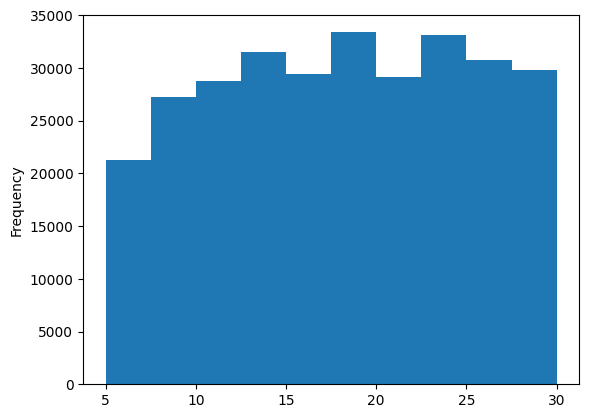

In [343]:
X_train['Weight Capacity (kg)'].plot(kind='hist')

In [344]:
X_train.columns

Index(['id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)'],
      dtype='object')

In [345]:
train.Compartments.unique()

array([ 7., 10.,  2.,  8.,  1.,  3.,  5.,  9.,  6.,  4.])

In [346]:
class modifyColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()

        X_new['WeightCat'] = pd.cut(X_new['Weight Capacity (kg)'], bins=3, labels=['Light', 'Medium', 'Heavy'])
        X_new['Compartments'] = X_new.Compartments.astype('int')
        X_new['PriceCat'] = pd.cut(train.Price, bins=3, labels=['Cheap', 'Medium', 'Expensive'])

        X_new.drop(['id'], axis=1, inplace=True)
        
        return X_new

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [348]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  
])

In [349]:
X_train_modify = modifyColumns().transform(X_train)

In [350]:
numerical_cols = [i for i in X_train_modify if X_train_modify[i].dtype == 'float64']
categorical_cols = [i for i in X_train_modify if X_train_modify[i].dtype != 'float64']

In [351]:
numerical_cols, categorical_cols

(['Weight Capacity (kg)'],
 ['Brand',
  'Material',
  'Size',
  'Compartments',
  'Laptop Compartment',
  'Waterproof',
  'Style',
  'Color',
  'WeightCat',
  'PriceCat'])

In [352]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols), 
        ('cat', categorical_transformer, categorical_cols)  
    ]
)

In [353]:
pipeline = Pipeline([
    ('modifyColumns', modifyColumns()),
    ('preprocessor', preprocessor),
    ('regressor', 'passtrough')
])

In [354]:
X_train_modify.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),WeightCat,PriceCat
0,Jansport,Leather,Medium,7,Yes,No,Tote,Black,11.611723,Light,Expensive
1,Jansport,Canvas,Small,10,Yes,Yes,Messenger,Green,27.078537,Heavy,Medium
2,Under Armour,Leather,Small,2,Yes,No,Messenger,Red,16.643760,Medium,Cheap
3,Nike,Nylon,Small,8,Yes,No,Messenger,Green,12.937220,Light,Medium
4,Adidas,Canvas,Medium,1,Yes,Yes,Messenger,Green,17.749338,Medium,Medium


<Axes: xlabel='Price', ylabel='Compartments'>

c:\Users\modern14\VSCode\GitHub\my-portfolio\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


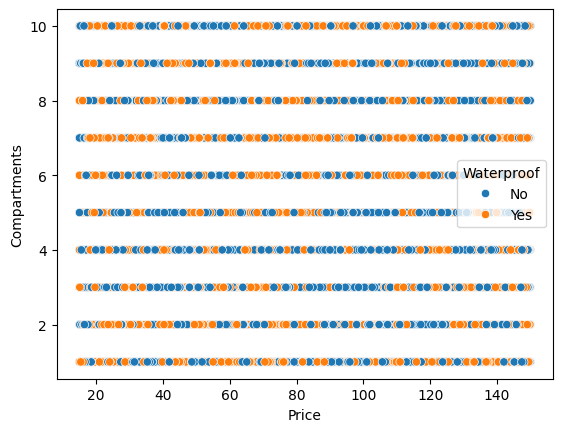

In [365]:
sns.scatterplot(train, x='Price', y='Compartments', hue='Waterproof')

In [272]:
# param_grid = [
#     {
#         'regressor': [CatBoostRegressor(verbose=False)],
#         'regressor__learning_rate': [0.01, 0.1],  
#         'regressor__depth': [6, 8],               
#         'regressor__iterations': [500, 1000],     
#         'regressor__l2_leaf_reg': [1, 5],         
#         'regressor__bagging_temperature': [0, 0.5]  
#     }
# ]

param_grid = [
    {
        'regressor': [CatBoostRegressor(verbose=False,  bagging_temperature= 0, depth=6, iterations=500, l2_leaf_reg=5, learning_rate=0.01)]
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)


Best parameters found:  {'regressor': <catboost.core.CatBoostRegressor object at 0x0000019F820F0E10>}
Best cross-validation score:  -1453.360432942821


In [279]:
y_train.shape

(3922238,)

In [273]:
test = pd.read_csv('data/test.csv')

In [274]:
test.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [275]:
best_model = grid_search.best_estimator_

y_test = best_model.predict(test)

print("Predictions: ", y_test)

Predictions:  [80.4155717  81.39704811 80.03809492 ... 80.56632349 80.51552076
 80.21677142]


In [276]:
result = pd.DataFrame(y_test, columns=['Price'])

In [277]:
test.join(result)[['id', 'Price']].to_csv('submission.csv', index=False)